In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt

In [2]:
# Load Mekong shapefile
mekong_watershed = gpd.read_file('data/mekong.geojson')

In [4]:
# https://www.hydrosheds.org/products/hydrorivers
# Read in hydrosheds dataset
# Filter to only include large rivers within mekong watershed
hr_url = 'data/external/HydroRIVERS_v10_as_shp'
rivers = gpd.read_file(hr_url, mask = mekong_watershed, where="ORD_FLOW < 5",)

In [5]:
rivers.head()

,HYRIV_ID,NEXT_DOWN,MAIN_RIV,LENGTH_KM,DIST_DN_KM,DIST_UP_KM,CATCH_SKM,UPLAND_SKM,ENDORHEIC,DIS_AV_CMS,ORD_STRA,ORD_CLAS,ORD_FLOW,HYBAS_L12,geometry
0,40603513,40604903,41392598,4.57,4467.0,379.2,16.52,17175.8,0,100.116,5,1,4,4120697620,"LINESTRING (96.46875 32.27292, 96.46875 32.268..."
1,40604903,40606396,41392598,4.92,4462.0,384.1,14.71,17214.1,0,100.421,5,1,4,4120697620,"LINESTRING (96.49375 32.23958, 96.49375 32.231..."
2,40606396,40606533,41392598,7.96,4454.0,392.1,42.15,17546.2,0,103.194,5,1,4,4120699270,"LINESTRING (96.49375 32.19792, 96.49375 32.193..."
3,40606533,40606826,41392598,1.39,4452.9,393.3,2.36,17561.8,0,103.350,5,1,4,4120699270,"LINESTRING (96.54792 32.15208, 96.55625 32.152..."
4,40606826,40607755,41392598,3.96,4448.7,397.5,23.63,17949.3,0,106.609,5,1,4,4121411960,"LINESTRING (96.56042 32.14792, 96.56458 32.143..."


<Axes: >

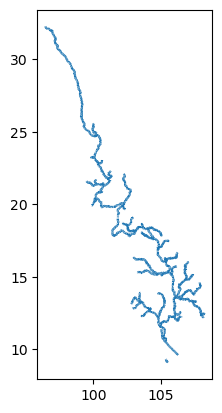

In [6]:
rivers.plot()

In [10]:
# Now read in GLRW dataset
glrw = gpd.read_file('data/external/GRWL_summaryStats_V01/', 
                     mask = mekong_watershed)


In [13]:
wide_rivers = glrw[glrw['width_mean'] > 150]
wide_rivers.crs == rivers.crs

True

In [14]:
mekong_watershed.bounds.minx[0]

93.85833333

In [15]:
# read in asia polygons file if it doesn't already exist
asia = gpd.read_file('data/external/asia_polygons.gpkg')

/tmp/ipykernel_1010/2076232433.py:1: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


<Axes: >

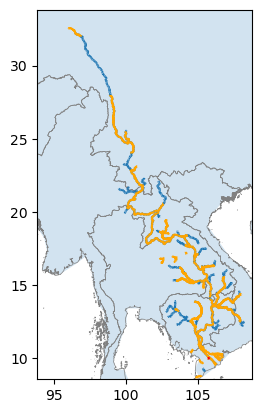

In [16]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
ax = world[world['continent'] == 'Asia'].plot(alpha = 0.2)
ax.set_xlim(mekong_watershed.bounds.minx[0], mekong_watershed.bounds.maxx[0])
ax.set_ylim(mekong_watershed.bounds.miny[0], mekong_watershed.bounds.maxy[0])
rivers.plot(ax=ax)
wide_rivers.plot(ax=ax, color = "orange")
asia.plot(ax=ax, facecolor='none', edgecolor='0.5', linewidth=0.5)
wide_rivers.iloc[0:1, :].plot(ax=ax, color = "red")

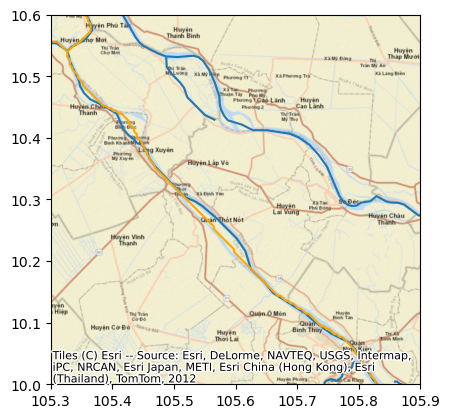

In [14]:
# So it turns out that landsat river reaches don't touch 
# and that they don't line up very well with hydrosheds reaches, 
# and then hydrosheds reaches are perhaps smaller than we want to work with. 
import contextily
ax = wide_rivers.plot()
rivers.plot(ax = ax, color = 'orange')
ax.set_xlim(105.3, 105.9)
ax.set_ylim(10.0, 10.6)
contextily.add_basemap(ax, 
                       crs=rivers.crs.to_string(), 
                       source=contextily.providers.Esri.WorldStreetMap)

In [15]:
wr = rivers[rivers.intersects(wide_rivers.unary_union)]

In [16]:
# set rivers geometries to projected crs
grwl = wide_rivers.to_crs('EPSG:32648')
hydro = rivers.to_crs('EPSG:32648')

grwl_buff = grwl.buffer(10000)


<Axes: >

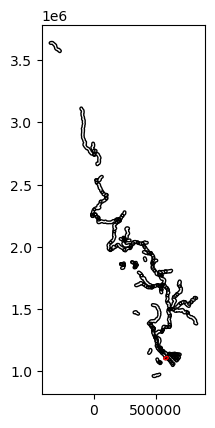

In [17]:
wr = grwl
wr['geometry'] = grwl.buffer(10000)
ax=wr.plot(facecolor='none')
wr.iloc[0:1, :].plot(ax=ax,facecolor='none', edgecolor='red')

In [18]:
# now make a recursive function to get everything connected to that guy
origin = wr.iloc[0]['geometry']
network = []
to_search = []
def find_connected_idx(gdf, origin_idx): 
    global to_search
    network.append(origin_idx)
    # get indices of everything connected to origin_idx 
    connected = gdf[gdf.intersects(gdf.loc[origin_idx]['geometry'])].index
    # filter these to only indices NOT already in the network
    new = [x for x in connected if x not in network]
    # or already in to_search list
    new = [x for x in new if x not in to_search]
    to_search = to_search + new
    if len(to_search) < 15:
        find_connected_idx(gdf, to_search.pop()) 
    return(network)


n = find_connected_idx(wr, 20)

<Axes: >

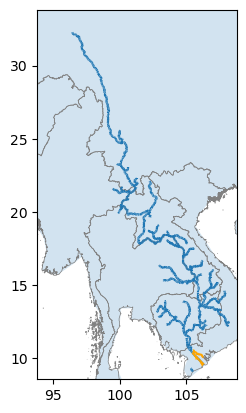

In [19]:
ax = world[world['continent'] == 'Asia'].plot(alpha = 0.2)
ax.set_xlim(mekong_watershed.bounds.minx[0], mekong_watershed.bounds.maxx[0])
ax.set_ylim(mekong_watershed.bounds.miny[0], mekong_watershed.bounds.maxy[0])
rivers.plot(ax=ax)
wide_rivers.loc[n].plot(ax=ax, color = "orange")
asia.plot(ax=ax, facecolor='none', edgecolor='0.5', linewidth=0.5)

In [20]:
# now plot with sentinel image
import helpers
from shapely import geometry
catalog = helpers.get_catalog()
# get bbox
(xmin, ymin, xmax, ymax)= [105.5, 13.2, 106.3, 13.8]
bbox = geometry.Polygon([[xmin, ymin], [xmax, ymin], [xmax, ymax], [xmin, ymax]])
bbox_gdf = gpd.GeoDataFrame({'geometry': [bbox]})
bbox_gdf.crs = wide_rivers.crs

In [21]:

search = catalog.search(
    collections=['sentinel-2-l2a'], # this includes all Landsats
    bbox=[xmin, ymin, xmax, ymax], 
    datetime="2023-11-20/2023-11-22"
)

In [22]:
items = search.item_collection() # pystac.ItemCollection
#sentinel = gpd.GeoDataFrame.from_features(items.to_dict(), crs="epsg:4326")
import odc.stac
data = odc.stac.stac_load(
    items, 
    bands=['B04', 'B03', 'B02','visual'], 
    bbox=[xmin, ymin, xmax, ymax],
).isel(time=0)

In [23]:
# get bbox in correct crs
bounds = bbox_gdf.to_crs('EPSG:32648').bounds.iloc[0]

(1459307.1215674905, 1525987.784603818)

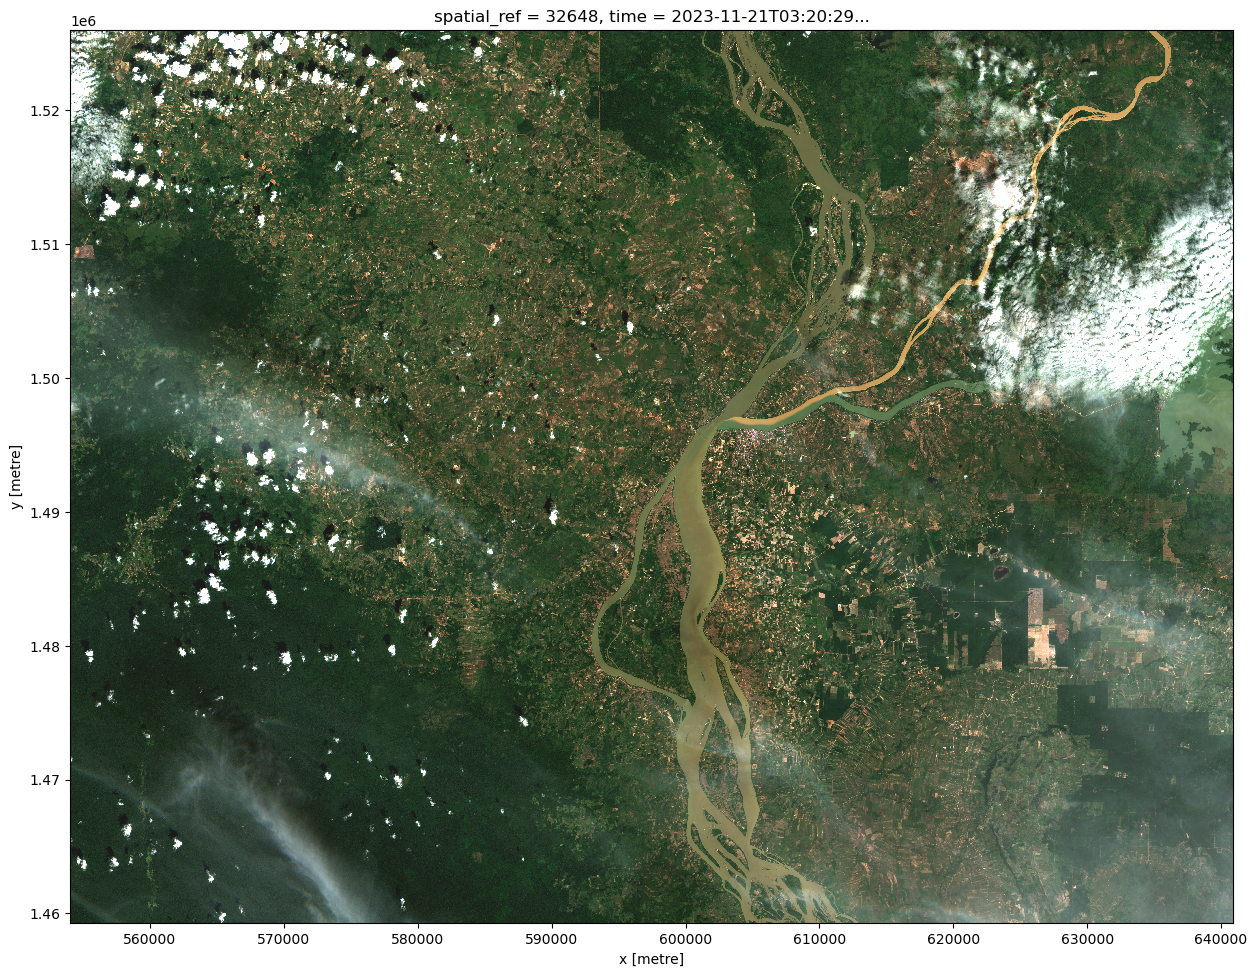

In [24]:
fig, ax = plt.subplots(figsize=(15, 15))
#d = data[['B04', 'B03', 'B02']].to_array()
#ax.axis('off')
ar = data[['B04', 'B03', 'B02']].to_array()
ar.plot.imshow(robust=True, ax=ax, alpha = 0.9)
# I will need to fix crs later...
# now add both sets of lines
wide_rivers.loc[n].to_crs('EPSG:32648').plot(ax=ax, color = "orange")
ax.set_xlim(bounds['minx'], bounds['maxx'])
ax.set_ylim(bounds['miny'], bounds['maxy'])